In [478]:
import sys
sys.path.append('../src/')
import matplotlib.pyplot as plt
from utils.visual_functions import *
from utils.utils import *
import numpy as np
from sklearn.manifold import TSNE
import matplotlib
import seaborn as sns
sns.color_palette('husl', n_colors=20)
%matplotlib inline
fig_path="../figure/paper/"
seed = 4783957
print("set seed")
np.random.seed(seed)
import torch
from utils.feature_representation import *

set seed


## Functions

In [479]:
def calculatePower(train_current, train_voltage, NN=500):
  

    n = len(current)
    PQ = np.empty([n,2])
    for i in range(n):
        # extract current and voltage in two cycle
        # extract current and voltage in two cycle
        temp_I = current[i]
        temp_V = voltage[i]
        Irms = np.mean(temp_I**2)**0.5
        Vrms = np.mean(temp_V**2)**0.5

        # Instantaneous power: obtained by multiplying the instantaneous voltage and current values
        Pinst = temp_I * temp_V
        Pactive = np.mean(Pinst) 

        # Apparent power: obtained by multiplying the RMS values of voltage and current
        Papparent = Vrms*Irms;

        # Ractive power if power triangle holds:
        Preactive = np.sqrt(Papparent**2 - Pactive**2);




        PQ[i,0]=Pactive
        PQ[i,1]=Preactive
    return PQ

def plot_PQPlane(labels, PQ, legends=None, sample=True):
    
    if legends:
        Legends=legends
    else:
        Legends=np.unique(labels)
        
    clrs = sns.color_palette("Paired", len(Legends))
    markers='1v^<P4ph+DX*8os3<-'
    
    minx,maxx,miny,maxy = (0,0,0,0)
    

    for i, app in enumerate(Legends):
        ix=np.where(labels==app)[0]
        if sample:
            ix1 = np.random.randint(PQ.shape[0],size=6)
            tempx = PQ[ix1,0]
            tempy = PQ[ix1,1]
        else:
            tempx = PQ[ix,0]
            tempy = PQ[ix,1]
        plt.scatter(tempx,tempy,marker=markers[i], s=30, label=Legends[i], color=clrs[i])
        minx = min(minx,min(tempx))
        maxx = max(maxx,max(tempx))
        miny = min(miny,min(tempy))
        maxy = max(maxy,max(tempy))    
    plt.axis([minx*0.9,maxx*1.1,miny*0.9,maxy*1.1])
    plt.xlabel('Real Power(W)')
    plt.ylabel('Reactive Power (VAR)')
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()

    
def tsne_visualizer(labels, feature, legends=None):
    if legends:
        Legends=legends
    else:
        Legends=np.unique(labels)
    clrs = sns.color_palette("Paired", len(Legends))
    model  = TSNE(perplexity=20, min_grad_norm=1E-12, n_iter=10000, random_state=42)
    #model = TSNE(n_components=2, random_state=0, perplexity=20, n_iter=1000)
    TSNEF  = model.fit_transform(feature.reshape(len(feature), -1))
    
    for i, app in enumerate(Legends):
        ix=np.where(labels==app)[0]
        plt.scatter(TSNEF[ix,0], TSNEF[ix,1],label=app, color=clrs[i])
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.xlabel("tsne-2d-one")
    plt.ylabel("tsne-2d-two")
    
def select_zc(voltage, Ts=500):
    zero_crossing = np.where(np.diff(np.sign(voltage)))[0]
    
    if voltage[zero_crossing[0]+1] > 0:
        zero_crossing = zero_crossing[0:]
    else:
        zero_crossing = zero_crossing[1:]
        
    if len(zero_crossing) % 2 == 1:
        zero_crossing = zero_crossing[:-1]
        
    if zero_crossing[-1] + Ts//2 >= len(voltage):
        zero_crossing = zero_crossing[:-2]
        
    return zero_crossing
    
    
def get_activations(c, v, Ts=500):
    current, voltage = np.copy(c), np.copy(v)
    zc=select_zc(voltage, Ts)
    print(zc)
    k = None
    for j in range(2, len(zc)-2):
        ts=zc[-j]-zc[-(j+2)]
        I=c[zc[-(j+2)]:zc[-j]]
        ic=zero_crossings(I)
        if ts==Ts and len(ic)>1 and len(I)>=Ts:
            k = j
            break

    if k is not None:
        voltage = voltage[zc[-(k+2)]:zc[-k]]
        current = current[zc[-(k+2)]:zc[-k]]
        correct = [zc[-(k+2)], zc[-k]]
    else:
        voltage = voltage[:Ts]
        current = np.zeros((Ts))
        correct = []
    return current, voltage, correct

def zero_crossings(voltage): 
    return np.where(np.diff(np.sign(voltage)))[0]

## Feature Extraction

In [480]:
import soundfile as sf
from data.load_cooll_data import get_cool_data
wanted_appl = ["Drill", "Fan", "Grinder", "Hair", "Hedge", "Lamp", "Sander", "Saw", "Vacuum"]
print("Load data")
Ts = int(100e3/50)
Nc = 10
cycles = Ts*Nc
path_dir = "../../data/COOLL/"
Meta, labels = get_cool_data(path_dir)
id = 1
start=Meta[id][4]
index_on  = Meta[id][0]*int(1e2)+Meta[id][3]
index_of = start*int(1e2)+Meta[id][7]+Meta[id][8]*int(1e2)
i, fs = sf.read(path_dir+"current/scenarioC1_{}.flac".format(id))
v, fs = sf.read(path_dir+"voltage/scenarioV1_{}.flac".format(id))

c_on,v_on = i[index_on-cycles:index_on+cycles], v[index_on-cycles:index_on+cycles]
c_of,v_of = i[index_of-Ts*5:index_of+Ts*5], v[index_of-Ts*5:index_of+Ts*5]

Load data


In [481]:
current, voltage = np.copy(c_on), np.copy(v_on)
c_a, v_a, zc_a=get_activations(c_on[Ts*Nc:], v_on[Ts*Nc:], Ts)
#c_b, v_b, zc_b=get_activations(c_on[:Ts*Nc], v_on[:Ts*Nc], Ts)

[  389  1389  2387  3388  4388  5389  6389  7389  8389  9389 10390 11390
 12390 13390 14390 15390 16390 17390]


In [482]:
def plot_events_sample(signal, zc_a, zc_b, label="voltage"):
    x = np.arange(len(signal))
    plt.plot(x, signal)
    plt.ylabel(label, fontsize=16)
    plt.xlabel("Sample $T_s\cdot N_s$", fontsize=16)
    plt.axvline(Ts*Nc,color=colors[3])
    ax = plt.gca()
    x_a_0=zc_a[0]+Ts*Nc//2
    x_a_1=zc_a[1]+Ts*Nc//2
    x_b_0=zc_b[0]
    x_b_1=zc_b[1]
    ax.plot(x[x_a_0:x_a_1], signal[x_a_0:x_a_1], color="r", alpha=0.9)
    ax.plot(x[x_b_0:x_b_1], signal[x_b_0:x_b_1], "g", alpha=0.9)
    ax.autoscale(tight=True)

In [484]:
fig = figure(fig_width=3)
plt.plot(c_a)
plt.ylabel("Current $A$", fontsize=16)
plt.xlabel("Sample $T_s$", fontsize=16)
ax = plt.gca()
ax.autoscale(tight=True)
savefig(fig_path+"current_after",format=".pdf")

In [485]:
fig = figure(fig_width=3)
plt.plot(v_a)
plt.ylabel("Voltage $V$", fontsize=16)
plt.xlabel("Sample $T_s$", fontsize=16)
ax = plt.gca()
ax.autoscale(tight=True)
savefig(fig_path+"voltage_after",format=".pdf")

In [486]:
fig = figure(fig_width=3)
plt.plot(v_b)
plt.ylabel("Voltage $V$", fontsize=16)
plt.xlabel("Sample $T_s$", fontsize=16)
ax = plt.gca()
ax.autoscale(tight=True)
savefig(fig_path+"voltage_before",format=".pdf")

In [487]:
fig = figure(fig_width=3)
plt.plot(c_b)
plt.ylim(-0.3, 0.3)
plt.ylabel("Current $A$", fontsize=16)
plt.xlabel("Sample $T_s$", fontsize=16)
plt.tight_layout()
savefig(fig_path+"current_before",format=".pdf")

In [488]:
fig = figure(fig_width=3)
plot_events_sample(current, zc_a, zc_b, label="current $A$")
savefig(fig_path+"Current_events",format=".pdf")

In [489]:
fig = figure(fig_width=3)
plot_events_sample(voltage, zc_a, zc_b, label="voltage $V$")
savefig(fig_path+"Volatge_events",format=".pdf")

### AWR

In [345]:
x_aa=paa(c_a, 500)
D=get_distance_measure(torch.tensor(x_aa[:,None]), p=2)
WRG=get_weighted_reccurrence_graph(D, 1e3, 50)

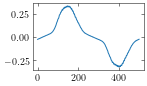

In [346]:
fig = figure(fig_width=2)
plt.plot(x_aa)

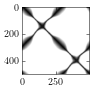

In [347]:
fig = figure(fig_width=2)
plt.imshow(WRG, cmap="gray")

### COOLL Data

In [445]:
from data.load_plaid_data import get_plaid_data
from data.load_cooll_data import get_cool_feature
from data.load_whited_data import get_whited_feature
datasets = {"plaid":"../../data/PLAID/",
               "whited":"../../data/WHITED/",
               "cooll":"../../data/COOLL/"}

data = "plaid"
current, voltage, label, _ = get_plaid_data(datasets[data])

Number of appliances:11 
Number of households:55             
Number of total measurements:1074
108/1074 (10%) have been read...	 time consumed: 58s
216/1074 (20%) have been read...	 time consumed: 117s
324/1074 (30%) have been read...	 time consumed: 171s
432/1074 (40%) have been read...	 time consumed: 228s
540/1074 (50%) have been read...	 time consumed: 287s
648/1074 (60%) have been read...	 time consumed: 350s
756/1074 (70%) have been read...	 time consumed: 407s
864/1074 (80%) have been read...	 time consumed: 475s
972/1074 (91%) have been read...	 time consumed: 561s
1074/1074 (100%) have been read(Done!) 	 time consumed: 615s
number of different appliances: 11
number of different households: 55


In [457]:
plaid_names = ['AC', 'CFL', 'Fan', 'Fridge', 'Hairdryer', 'Heater', 'Bulb', 'Laptop', 'Microwave', 'Vacuum', 'Washer']

In [464]:
plaid_label =[]
for l in label:
    plaid_label.append(plaid_names[l])

In [477]:
label, counts=np.unique(plaid_label, return_counts=True)
volgorde = np.argsort(counts)[::-1][:len(counts)]
fig = figure(fig_width=6)
plt.bar(label[volgorde], counts[volgorde], color=colors[0])
plt.xticks(rotation=90, fontsize=16)
ax = plt.gca()  
ax.set_ylabel(f'Number of activations', fontsize=16)
ax.set_xlabel("", fontsize=16)
ax.tick_params(axis='both', which='major')  
ax.autoscale(tight=True)
ax = plt.gca()
ax.tick_params(axis="both", which="minor", bottom=False, 
               top=False, labelbottom=True, left=False, right=False, labelleft=True)
format_axes(ax)
savefig(fig_path+"label_distribution_plaid",format=".pdf")

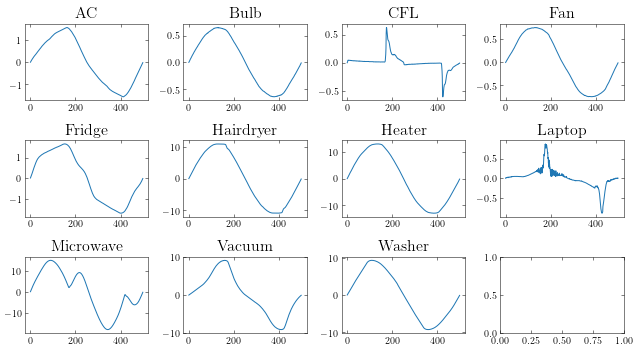

In [465]:
fig, axs = plt.subplots(3,4, figsize=set_figure_size(fig_width=9, fig_height=5))
#fig.subplots_adjust(hspace = 0.1)
axs = axs.ravel()
for idap, app in enumerate(np.unique(plaid_label)):
    idx = np.random.choice(np.where(np.array(plaid_label)==app)[0])
    axs[idap].plot(current[idx]) 
    axs[idap].set_title(app, fontsize=16)
    #axs[idap].set_xlabel("$(V)$", fontsize=12) 
    #axs[idap].set_ylabel("$(A)$", fontsize=12) 
    #axs[idap].set_xlim(0, 501) 
    #format_axes(axs[idap])
    #axs[idap].autoscale(tight=True)
    handles, labels = axs[idap].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',  ncol=3, fontsize=14)
fig.tight_layout()

In [263]:
hair = np.where(label=="Hair")[0][0]

In [365]:
fig = figure(fig_width=3)
vc= np.random.choice(np.where(np.unique(label)==9)[0])
plt.plot(current[vc])
plt.ylabel("Current $A$")
plt.xlabel("Sample $T_s$")
savefig(fig_path+"CFL_before_paa",format=".pdf")


fig = figure(fig_width=3)
vc= np.random.choice(np.where(np.unique(label)==9)[0])
plt.plot(paa(current[vc], 50))
plt.ylabel("Current $A$")
plt.xlabel("Sample $T_s$")
savefig(fig_path+"CFL_before_paa_50",format=".pdf")

fig = figure(fig_width=3)
vc= np.random.choice(np.where(np.unique(label)==9)[0])
plt.plot(paa(current[vc], 30))
plt.ylabel("Current $A$")
plt.xlabel("Sample $T_s$")
savefig(fig_path+"CFL_before_paa_30",format=".pdf")

fig = figure(fig_width=3)
vc= np.random.choice(np.where(np.unique(label)==9)[0])
plt.plot(paa(current[vc], 20))
plt.ylabel("Current $A$")
plt.xlabel("Sample $T_s$")
savefig(fig_path+"CFL_before_paa_20",format=".pdf")

fig = figure(fig_width=3)
vc= np.random.choice(np.where(np.unique(label)==9)[0])
plt.plot(paa(current[vc], 10))
plt.ylabel("Current $A$")
plt.xlabel("Sample $T_s$")
savefig(fig_path+"CFL_before_paa_10",format=".pdf")

In [416]:
fig = figure(fig_width=3, fig_height=2.5)
plt.plot(voltage[vc], current[vc])
#plt.plot( voltage[dr], current[dr])
plt.ylabel("Current $A$")
plt.xlabel("Voltage $V$")
savefig(fig_path+"VC_VI",format=".pdf")

fig = figure(fig_width=3, fig_height=2.5)
plt.plot(voltage[vc])
#plt.ylabel("Current $A$")
#plt.xlabel("Voltage $V$")
savefig(fig_path+"V",format=".pdf")
fig = figure(fig_width=3, fig_height=2.5)
plt.plot(current[vc])
plt.ylabel("Current $A$")
#plt.xlabel("Voltage $V$")
savefig(fig_path+"I",format=".pdf")

In [369]:
D=get_distance_measure(torch.tensor(paa(current[vc], 50)[:,None]), p=2)
WRG=get_weighted_reccurrence_graph(D, 1e1, 20)
RG=get_weighted_reccurrence_graph(D, 1e1, 1)

In [405]:
fig = figure(fig_width=2.5, fig_height=2.5)
plt.imshow(D, cmap="Spectral");
savefig(fig_path+"distance",format=".pdf")

In [406]:
fig = figure(fig_width=2.5, fig_height=2.5)
plt.imshow(WRG, cmap="Spectral");
savefig(fig_path+"wrg",format=".pdf")

In [407]:
fig = figure(fig_width=2.5, fig_height=2.5)
plt.imshow(RG, cmap="gray");
savefig(fig_path+"binaryrg",format=".pdf")

In [420]:
VIv = get_img_from_VI(current[vc], voltage[vc], 50)
fig = figure(fig_width=2, fig_height=1.5)
plt.imshow(VIv, cmap="binary");
savefig(fig_path+"VI-image",format=".pdf")

### LABEL DISTRIBUTION

In [428]:
data = "cooll"
current, voltage, label, = get_cool_feature(datasets[data])

Load data


processed: 839: 100%|█████████▉| 839/841 [00:25<00:00, 32.38it/s]


labels:839
current:839
voltage:839


In [429]:
cool_label = label

In [476]:
label, counts=np.unique(cool_label, return_counts=True)
volgorde = np.argsort(counts)[::-1][:len(counts)]
fig = figure(fig_width=6)
plt.bar(label[volgorde], counts[volgorde], color=colors[0])
plt.xticks(rotation=90, fontsize=16)
ax = plt.gca()  
ax.set_ylabel(f'Number of activations', fontsize=16)
ax.set_xlabel("", fontsize=16)
ax.tick_params(axis='both', which='major')  
ax.autoscale(tight=True)
ax = plt.gca()
ax.tick_params(axis="both", which="minor", bottom=False, 
               top=False, labelbottom=True, left=False, right=False, labelleft=True)
format_axes(ax)
savefig(fig_path+"label_distribution_cooll",format=".pdf")

In [435]:
from data.load_whited_data import get_whited_feature, get_train_test_leave_out_whited 
datasets = {"plaid":"../../data/PLAID/",
               "whited":"../../data/WHITED/",
               "cooll":"../../data/COOLL/"}
data = "whited"
current, voltage, label = get_whited_feature(datasets[data])
whited_label = label

processed: 1259: 100%|██████████| 1259/1259 [00:07<00:00, 160.96it/s]


In [475]:

label, counts=np.unique(whited_label, return_counts=True)
volgorde = np.argsort(counts)[::-1][:len(counts)]
fig = figure(fig_width=12, fig_height=5)
plt.bar(label[volgorde], counts[volgorde], color=colors[0])
plt.xticks(rotation=90, fontsize=16)
ax = plt.gca()  
ax.set_ylabel(f'Number of activations', fontsize=16)
ax.set_xlabel("", fontsize=16)
ax.tick_params(axis='both', which='major')  
ax.autoscale(tight=True)
ax = plt.gca()
ax.tick_params(axis="both", which="minor", bottom=False, 
               top=False, labelbottom=True, left=False, right=False, labelleft=True)
format_axes(ax)
savefig(fig_path+"label_distribution_whited",format=".pdf")